In [123]:
from utils.dataloader import FifaStatDatabase
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [125]:
db = FifaStatDatabase('FifaStat.sqlite')

# Denormalize Database

In [126]:
df_match_denorm = db.execute_query_df("""
    SELECT m.season, m.home_team_goal, m.away_team_goal, l.name as league_name, c.name as country_name, 
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
    FROM Match m
    LEFT JOIN League l ON m.league_id = l.id
    LEFT JOIN Country c ON m.country_id = c.id
    LEFT JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    LEFT JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
""")
df_match_denorm

,season,home_team_goal,away_team_goal,league_name,country_name,home_team_name,away_team_name
0,2008/2009,1,1,Belgium Jupiler League,Belgium,KRC Genk,Beerschot AC
1,2008/2009,0,0,Belgium Jupiler League,Belgium,SV Zulte-Waregem,Sporting Lokeren
2,2008/2009,0,3,Belgium Jupiler League,Belgium,KSV Cercle Brugge,RSC Anderlecht
3,2008/2009,5,0,Belgium Jupiler League,Belgium,KAA Gent,RAEC Mons
4,2008/2009,1,3,Belgium Jupiler League,Belgium,FCV Dender EH,Standard de Liège
...,...,...,...,...,...,...,...
25974,2015/2016,1,0,Switzerland Super League,Switzerland,FC St. Gallen,FC Thun
25975,2015/2016,1,2,Switzerland Super League,Switzerland,FC Vaduz,FC Luzern
25976,2015/2016,2,0,Switzerland Super League,Switzerland,Grasshopper Club Zürich,FC Sion
25977,2015/2016,0,0,Switzerland Super League,Switzerland,Lugano,FC Zürich


In [127]:
df_match_denorm['WinLossDraw'] = df_match_denorm.apply(lambda x: 'Home Win' if x['home_team_goal'] > x['away_team_goal'] else ('Away Win' if x['home_team_goal'] < x['away_team_goal'] else 'Draw'), axis=1)
df_match_denorm['WinLossDraw'].value_counts() / df_match_denorm['WinLossDraw'].count() * 100

WinLossDraw
Home Win    45.871666
Away Win    28.738597
Draw        25.389738
Name: count, dtype: float64

In [128]:
# Nan verify
df_match_denorm.isna().sum()

season            0
home_team_goal    0
away_team_goal    0
league_name       0
country_name      0
home_team_name    0
away_team_name    0
WinLossDraw       0
dtype: int64

In [129]:
# Calculate home and away win rates by team
team_stats = pd.DataFrame()

# Home win rates
home_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Home Win']['home_team_name'].value_counts()
home_total = df_match_denorm['home_team_name'].value_counts()
home_win_rates = (home_wins / home_total).fillna(0)

# Away win rates
away_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Away Win']['away_team_name'].value_counts()
away_total = df_match_denorm['away_team_name'].value_counts()
away_win_rates = (away_wins / away_total).fillna(0)

# Create dataframe for plotting
team_stats['home_win_rate'] = home_win_rates
team_stats['away_win_rate'] = away_win_rates

Text(0, 0.5, 'Away Win Rate')

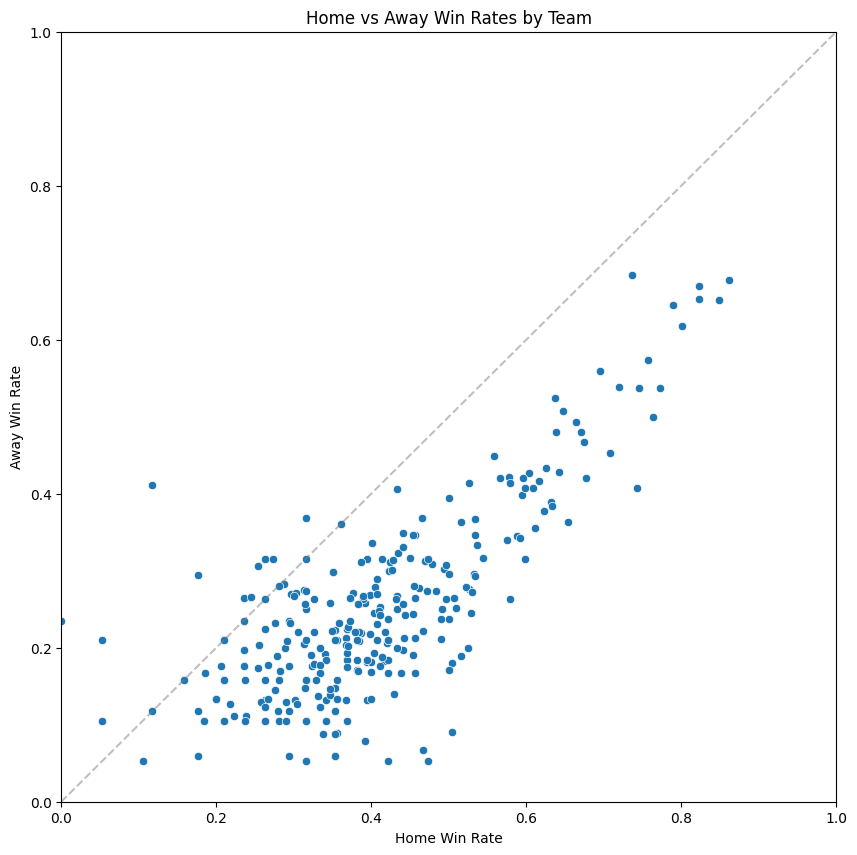

In [130]:
import seaborn as sns

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

# Add y=x line
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)

# Create scatter plot with team names
sns.scatterplot(data=team_stats, x='home_win_rate', y='away_win_rate')

# Add team names as annotations
# for idx in team_stats.index:
#     plt.annotate(idx,
#                  (team_stats.loc[idx, 'home_win_rate'],
#                   team_stats.loc[idx, 'away_win_rate']),
#                  xytext=(5, 5), textcoords='offset points',
#                  fontsize=6)

plt.title('Home vs Away Win Rates by Team')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Home Win Rate')
plt.ylabel('Away Win Rate')

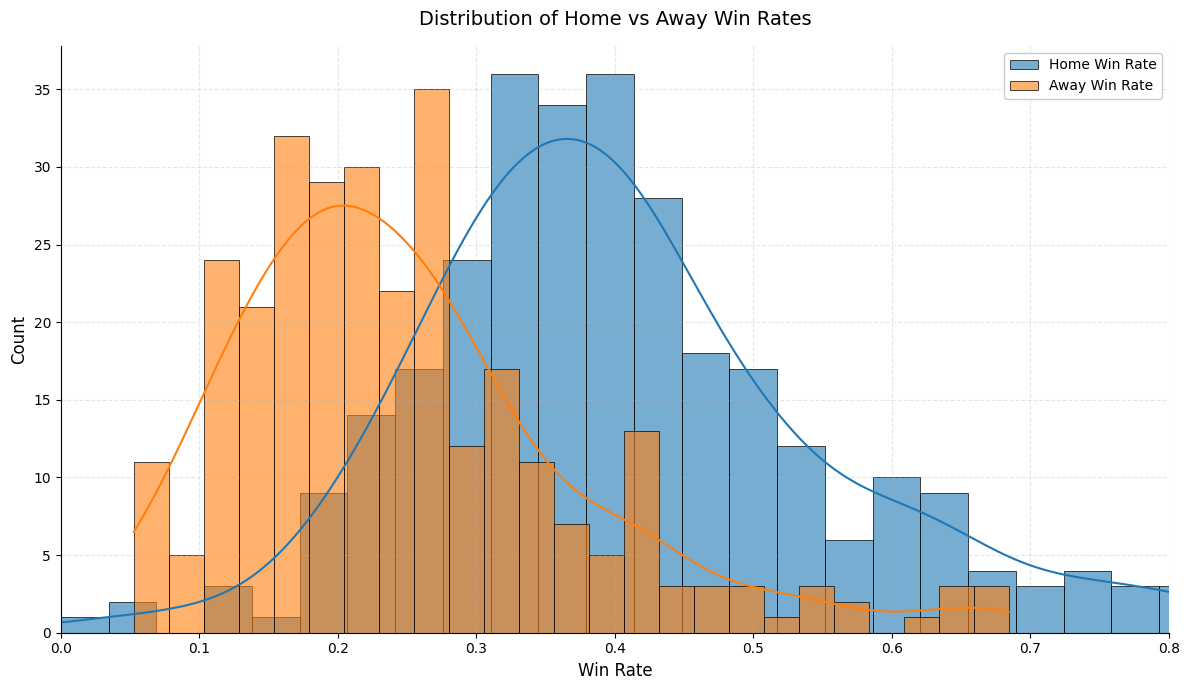

In [131]:
plt.figure(figsize=(12, 7))

# # Set style
# plt.style.use('seaborn')

# Create KDE plots with better colors and styling
sns.histplot(data=team_stats['home_win_rate'], label='Home Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)
sns.histplot(data=team_stats['away_win_rate'], label='Away Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)

# Customize the plot
plt.title('Distribution of Home vs Away Win Rates', fontsize=14, pad=15)
plt.xlabel('Win Rate', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Customize legend
plt.legend(frameon=True, facecolor='white', framealpha=1, fontsize=10)

# Add grid and customize its appearance
plt.grid(True, alpha=0.3, linestyle='--')

# Set x-axis limits for better visualization
plt.xlim(0, 0.8)

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

In [137]:
from scipy import stats

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(team_stats['home_win_rate'], team_stats['away_win_rate'])

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4e}")
# Check if the difference is statistically significant at α = 0.05
if p_value < 0.05:
    print("There is a statistically significant difference between home and away win rates")
else:
    print("No significant difference between home and away win rates")
print("\nMedian win rates:")
print(f"Home: {team_stats['home_win_rate'].median():.4f}")
print(f"Away: {team_stats['away_win_rate'].median():.4f}")

t-statistic: 28.6036
p-value: 4.6152e-87
There is a statistically significant difference between home and away win rates

Median win rates:
Home: 0.3856
Away: 0.2229


<Figure size 1200x600 with 0 Axes>

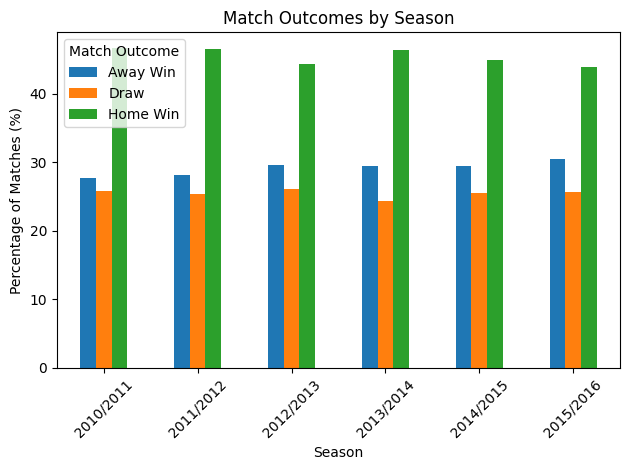

In [147]:
# Calculate the percentage of each outcome per season
season_outcomes = pd.crosstab(df_match_denorm['season'], df_match_denorm['WinLossDraw'], normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(12, 6))
season_outcomes.iloc[2:, :].plot(kind='bar', stacked=False)

plt.title('Match Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Percentage of Matches (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Match Outcome')

# Adjust layout to prevent label cutoff
plt.tight_layout()

<Figure size 1500x800 with 0 Axes>

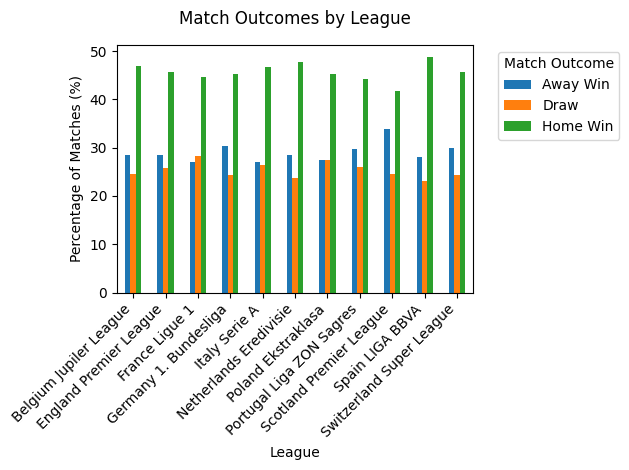

In [145]:
# Calculate win/loss/draw rates for each league
league_outcomes = pd.crosstab(df_match_denorm['league_name'], 
                            df_match_denorm['WinLossDraw'], 
                            normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(15, 8))
league_outcomes.plot(kind='bar', stacked=False)

plt.title('Match Outcomes by League', fontsize=12, pad=15)
plt.xlabel('League', fontsize=10)
plt.ylabel('Percentage of Matches (%)', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Match Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

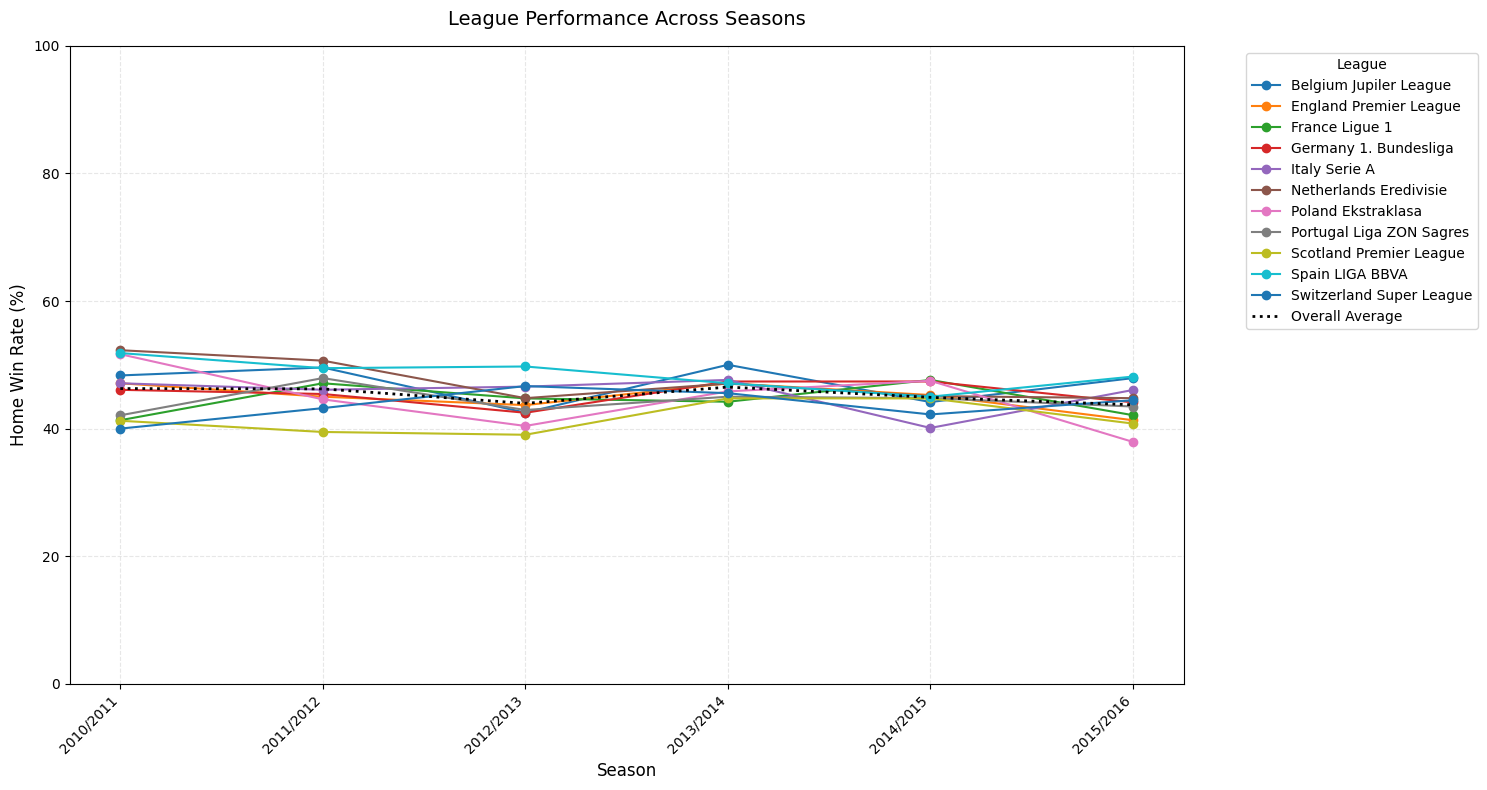

In [180]:
# Create pivot table for league performance by season
league_season_data = df_match_denorm.pivot_table(
    index='league_name',
    columns='season',
    values='WinLossDraw',
    aggfunc=lambda x: (x == 'Home Win').mean() * 100
)

league_season_data = league_season_data.iloc[:, 2:]

# Create the plot
plt.figure(figsize=(15, 8))

# Plot lines for each league
for league in league_season_data.index:
    plt.plot(league_season_data.columns,
             league_season_data.loc[league],
             marker='o',
             label=league)

# Calculate and plot overall season averages
season_averages = league_season_data.mean()
plt.plot(league_season_data.columns, 
         season_averages, 
         'k:',  # black dotted line
         linewidth=2, 
         label='Overall Average')

# Customize the plot
plt.title('League Performance Across Seasons', fontsize=14, pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Home Win Rate (%)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend with better positioning
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

plt.ylim(0, 100)  # Set y-axis limits for better visualization

# Adjust layout to prevent label cutoff
plt.tight_layout()